<a href="https://colab.research.google.com/github/mirtorande/muffin-vs-chihuahua/blob/main/MuffinsChihuahuas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
! pip install -qq wandb
import wandb
from wandb.keras import WandbMetricsLogger
wandb.login()
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold

wandb: Currently logged in as: mirtorande (minigi). Use `wandb login --relogin` to force relogin


In [2]:
# Define a config dictionary object
configs = dict(
    image_size = 64,
    batch_size= 32,
    init_learning_rate = 1e-3,
    epochs = 50,
    dropout = 0.1,
    optimizer = 'adam',
    loss_fn = 'binary_crossentropy',
    metrics = ['acc'],
)

## Load the data: the Muffins vs Chihuahuas dataset

### Data download


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = "/content/drive/My Drive/Datasets/archive"

### Filter out the corrupted images

In [5]:
"""num_skipped = 0
for folder_name in ('test/chihuahua', 'train/chihuahua', 'test/muffin', 'train/muffin'):
    folder_path = os.path.join(dataset_path, folder_name)
    for fname in tqdm(os.listdir(folder_path)):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)"""


'num_skipped = 0\nfor folder_name in (\'test/chihuahua\', \'train/chihuahua\', \'test/muffin\', \'train/muffin\'):\n    folder_path = os.path.join(dataset_path, folder_name)\n    for fname in tqdm(os.listdir(folder_path)):\n        fpath = os.path.join(folder_path, fname)\n        try:\n            fobj = open(fpath, "rb")\n            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)\n        finally:\n            fobj.close()\n\n        if not is_jfif:\n            num_skipped += 1\n            # Delete corrupted image\n            os.remove(fpath)\n\nprint("Deleted %d images" % num_skipped)'

### Generate a Dataset

In [6]:
def load_datasets(config, use_val=True):
  """
  Loads Training and Test datasets
  """
  image_size = (config['image_size'], config['image_size']) # (224, 224) originally
  batch_size = config['batch_size']

  if use_val:
    train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        validation_split = 0.2,
        subset='both',
        shuffle=True,
        seed=1337
    )
  else:
    train_ds = tf.keras.utils.image_dataset_from_directory(
        dataset_path + '/train',
        image_size=image_size,
        batch_size=batch_size,
        shuffle=True,
        seed=1337
    )
    val_ds = None

  test_ds = tf.keras.utils.image_dataset_from_directory(
      dataset_path + '/test',
      image_size=image_size,
      batch_size=batch_size,
      shuffle=False
  )
  return train_ds, val_ds, test_ds

## Visualize the data

In [7]:
def print_class_counts(dataset):
  n_muf=0
  n_chi = 0
  for images, labels in tqdm(dataset):
    for label in labels:
      if label == 0:
        n_chi += 1
      else:
        n_muf += 1

  print(n_muf, n_chi)

In [8]:
def show_sample_figures(dataset):
  plt.figure(figsize=(10, 10))
  for images, labels in dataset.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(int(labels[i]))
          plt.axis("off")

## Using image data augmentation

In [9]:
def augment_dataset(dataset, show_preview=False):
  data_augmentation = keras.Sequential(
      [
          layers.RandomFlip("horizontal"),
          layers.RandomRotation(0.1),
      ]
  )

  # Show augmentation preview
  if show_preview:
    plt.figure(figsize=(10, 10))
    for images, _ in dataset.take(1):
        for i in range(9):
            augmented_images = data_augmentation(images)
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(augmented_images[1].numpy().astype("uint8"))
            plt.axis("off")

  # Apply `data_augmentation` to the training images.
  dataset = dataset.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
  )

  return dataset

In [10]:
def prefetch_datasets(*args):
  # Prefetching samples in GPU memory helps maximize GPU utilization.
  for i in range(len(args)):
    args[i] = args[i].prefetch(tf.data.AUTOTUNE)
  return args

# Build the model

In [75]:
def make_model(config, input_shape, num_classes):
  inputs = keras.Input(shape=input_shape)

  # Entry block
  x = layers.Rescaling(1.0 / 255)(inputs)
  x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  previous_block_activation = x  # Set aside residual

  for size in [128]:
      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.Activation("relu")(x)
      x = layers.SeparableConv2D(size, 3, padding="same")(x)
      x = layers.BatchNormalization()(x)

      x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

      # Project residual
      residual = layers.Conv2D(size, 1, strides=2, padding="same")(
          previous_block_activation
      )
      x = layers.add([x, residual])  # Add back residual
      previous_block_activation = x  # Set aside next residual

  x = layers.SeparableConv2D(256, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.GlobalAveragePooling2D()(x)
  if num_classes == 2:
      activation = "sigmoid"
      units = 1
  else:
      activation = "softmax"
      units = num_classes

  x = layers.Dropout(config['dropout'])(x)
  outputs = layers.Dense(units, activation=activation)(x)

  return keras.Model(inputs, outputs)

# Train the model

In [56]:
def train_model(config, train_ds, test_ds):
  model = make_model(config, input_shape=(config.image_size, config.image_size) + (3,), num_classes=2)
  keras.utils.plot_model(model, show_shapes=True)

  epochs = config.epochs

  model.compile(
      optimizer=keras.optimizers.Adam(config.init_learning_rate),
      loss=config.loss_fn,
      metrics=["accuracy"],
  )

  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch=5), WandbMetricsLogger(log_freq=2)]

  history = model.fit(
      train_ds,
      epochs=epochs,
      callbacks=callbacks,
      validation_data=test_ds,
  )
  return history

# Objective

In [13]:
def objective(config):
  train, val, _ = load_datasets(config)
  print_class_counts(train)
  show_sample_figures(train)
  train = augment_dataset(train, show_preview=True)
  train, val = prefetch_datasets(train, val)
  history = train_model(config, train, val)
  return max(history.history['val_accuracy'])

In [57]:
train, _, _ = load_datasets(wandb.config, use_val=False)
train = augment_dataset(train, show_preview=False)

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.


In [73]:
def objective_5fold(config):
  #train, _, _ = load_datasets(config, use_val=False)
  #print_class_counts(train)
  #show_sample_figures(train)
  #train = augment_dataset(train, show_preview=False)

  #TODO: trovare una versione più veloce
  train_batched_x = list(train.map(lambda x, y: x))
  train_x = []
  for batch in train_batched_x:
      for element in batch:
          train_x.append(element)
  train_batched_y = list(train.map(lambda x, y: y))
  train_y = []
  for batch in train_batched_y:
      for element in batch:
          train_y.append(element)

  accuracies = []

  for train_indexes, val_indexes in StratifiedKFold(n_splits=5).split(train_x, train_y):

    fold_train_x = []
    fold_train_y = []
    for i in train_indexes:
      fold_train_x.append(train_x[i])
      fold_train_y.append(train_y[i])

    fold_val_x = []
    fold_val_y = []
    for i in val_indexes:
      fold_val_x.append(train_x[i])
      fold_val_y.append(train_y[i])

    model = make_model(config, input_shape=(config.image_size, config.image_size) + (3,), num_classes=2)

    epochs = config.epochs

    model.compile(
        optimizer=keras.optimizers.Adam(config.init_learning_rate),
        loss=config.loss_fn,
        metrics=["accuracy"],
    )

    callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, start_from_epoch=15), WandbMetricsLogger(log_freq=2)]

    history = model.fit(
        np.array(fold_train_x), np.array(fold_train_y),
        epochs=epochs,
        batch_size=config.batch_size,
        callbacks=callbacks,
        validation_data=(np.array(fold_val_x), np.array(fold_val_y)),
    )
    accuracies.append(max(history.history['val_accuracy']))

    # training preds
    for i in range(10):
      img = fold_train_x[i]
      predictions = model.predict(np.reshape(img,(1,64,64,3)))
      score = float(predictions[0])
      ground_truth = fold_train_y[i]
      print(f"This image is {100 * (1 - score):.2f}% muffin and {100 * score:.2f}% chihuahua. and it should be {ground_truth}")
      plt.imshow(img/255)
      plt.title(int(ground_truth))
      plt.axis("off")
      plt.show()

    # validation preds
    for i in range(10):
      img = fold_val_x[i]
      predictions = model.predict(np.reshape(img,(1,64,64,3)))
      score = float(predictions[0])
      ground_truth = fold_val_y[i]
      print(f"This image is {100 * (1 - score):.2f}% muffin and {100 * score:.2f}% chihuahua. and it should be {ground_truth}")
      plt.imshow(img/255)
      plt.title(int(ground_truth))
      plt.axis("off")
      plt.show()

  return np.mean(accuracies)

batch/accuracy,▆▆▆▆▆▅▅▅▅▄▄▅▅▁▆▅▅▅▆▅▅▅▇▆▆▅▅▃▄▅▅█▇▆▆▆▆▅▅▆
batch/batch_step,▁▁▂▃▃▄▄▅▅▁▁▂▃▃▄▄▅▅▁▂▂▃▃▄▄▅▆▁▂▂▃▃▄▄▅▆▆▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▄▃▃▃▃▂▂▂▂█▆▅▄▃▁▂▂▂▆▃▃▃▂▃▂▂▂▇▅▄▃▄▂▂▂▂▃▂▂▂
epoch/accuracy,▇▁▃▅▂▄▁█▅
epoch/epoch,▁▅▁▅▁▅▁▅█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁
epoch/loss,▄▃█▁▅▄▇▃▁
epoch/val_accuracy,▇▃██████▁
epoch/val_loss,▂▂▁▁▁▁▁▁█
batch/accuracy,0.5202


Epoch 1/50
119/119 [==============================] - 8s 28ms/step - loss: 0.7179 - accuracy: 0.5151 - val_loss: 0.6940 - val_accuracy: 0.4636
Epoch 2/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7038 - accuracy: 0.5172 - val_loss: 0.6902 - val_accuracy: 0.5407
Epoch 3/50
119/119 [==============================] - 3s 23ms/step - loss: 0.6994 - accuracy: 0.5227 - val_loss: 0.6902 - val_accuracy: 0.5470
Epoch 4/50
119/119 [==============================] - 3s 23ms/step - loss: 0.7000 - accuracy: 0.5269 - val_loss: 0.6920 - val_accuracy: 0.5385
Epoch 5/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6970 - accuracy: 0.5243 - val_loss: 0.7086 - val_accuracy: 0.4900
Epoch 6/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6950 - accuracy: 0.5335 - val_loss: 0.6995 - val_accuracy: 0.4921
Epoch 7/50
119/119 [==============================] - 3s 23ms/step - loss: 0.6982 - accuracy: 0.5203 - val_loss: 0.6941 - val_accuracy: 0.5417

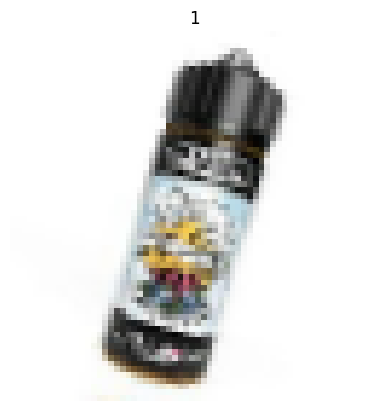

1/1 [==============================] - 0s 29ms/step
This image is 57.00% muffin and 43.00% chihuahua. and it should be 1


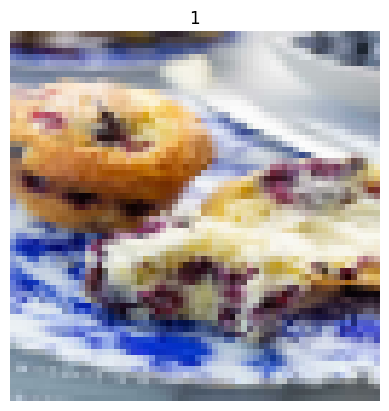

1/1 [==============================] - 0s 25ms/step
This image is 54.88% muffin and 45.12% chihuahua. and it should be 1


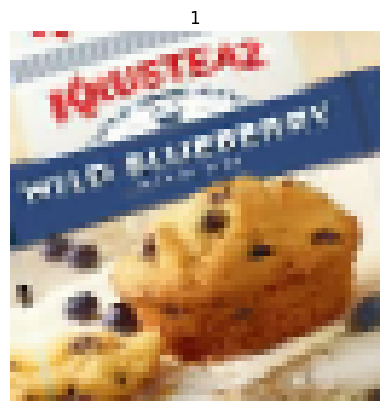

1/1 [==============================] - 0s 26ms/step
This image is 53.96% muffin and 46.04% chihuahua. and it should be 1


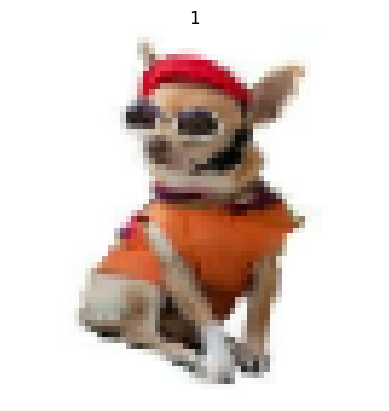

1/1 [==============================] - 0s 26ms/step
This image is 57.33% muffin and 42.67% chihuahua. and it should be 1


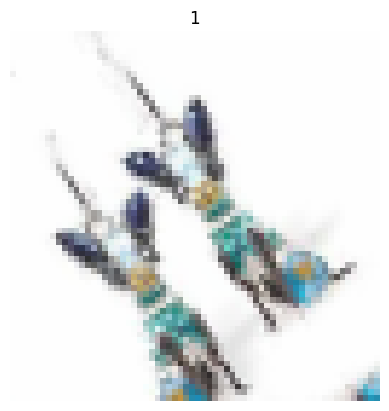

1/1 [==============================] - 0s 23ms/step
This image is 41.88% muffin and 58.12% chihuahua. and it should be 1


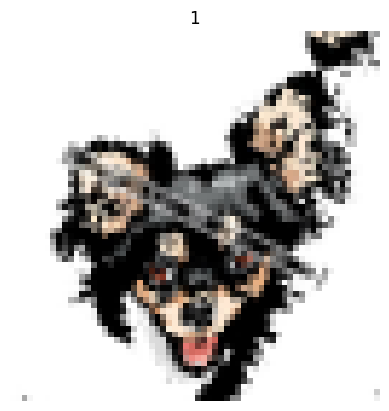

1/1 [==============================] - 0s 25ms/step
This image is 64.39% muffin and 35.61% chihuahua. and it should be 1


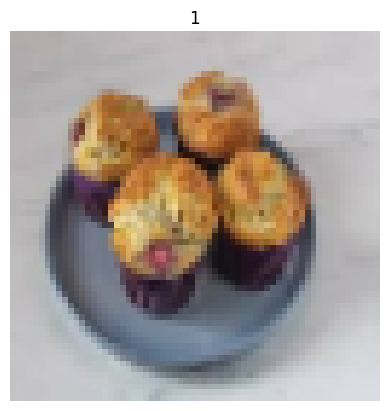

1/1 [==============================] - 0s 23ms/step
This image is 67.58% muffin and 32.42% chihuahua. and it should be 1


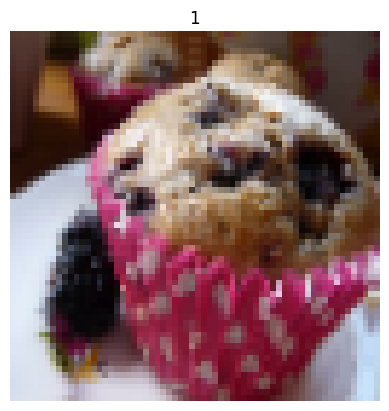

1/1 [==============================] - 0s 24ms/step
This image is 48.22% muffin and 51.78% chihuahua. and it should be 1


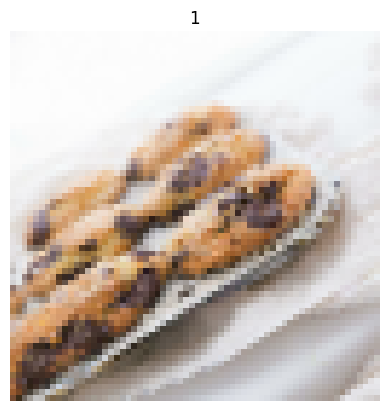

1/1 [==============================] - 0s 23ms/step
This image is 59.28% muffin and 40.72% chihuahua. and it should be 1


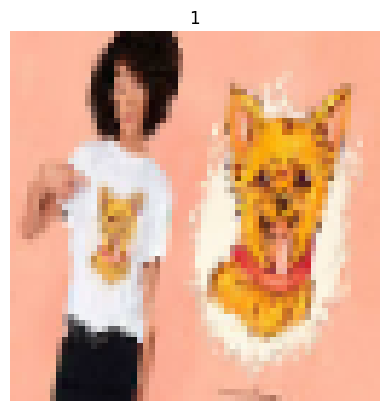

1/1 [==============================] - 0s 23ms/step
This image is 65.43% muffin and 34.57% chihuahua. and it should be 0


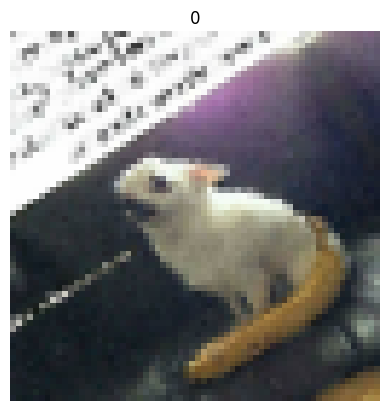

1/1 [==============================] - 0s 24ms/step
This image is 36.65% muffin and 63.35% chihuahua. and it should be 0


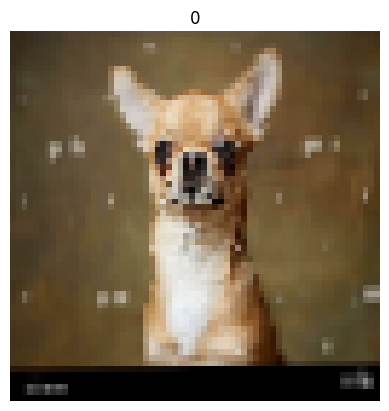

1/1 [==============================] - 0s 23ms/step
This image is 43.68% muffin and 56.32% chihuahua. and it should be 0


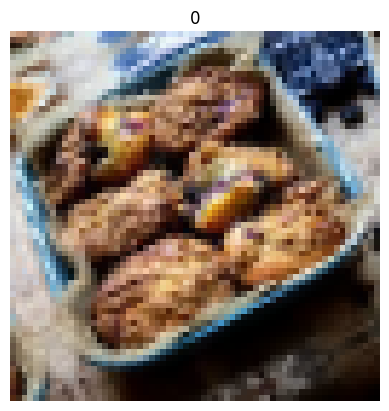

1/1 [==============================] - 0s 23ms/step
This image is 56.40% muffin and 43.60% chihuahua. and it should be 0


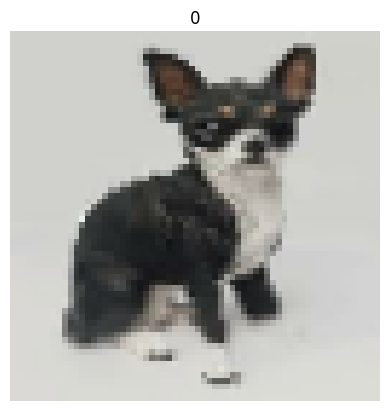

1/1 [==============================] - 0s 24ms/step
This image is 58.62% muffin and 41.38% chihuahua. and it should be 1


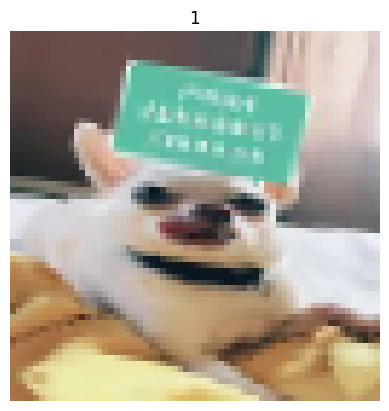

1/1 [==============================] - 0s 24ms/step
This image is 61.29% muffin and 38.71% chihuahua. and it should be 0


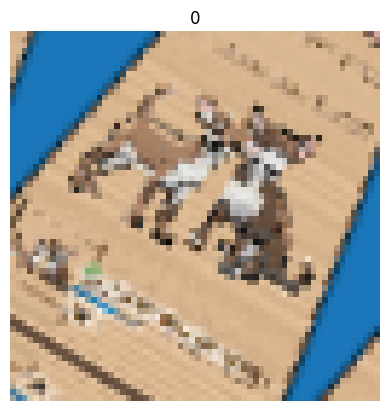

1/1 [==============================] - 0s 23ms/step
This image is 44.93% muffin and 55.07% chihuahua. and it should be 0


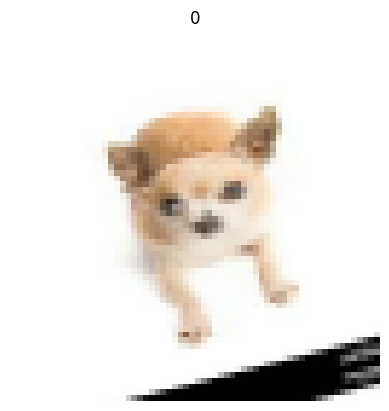

1/1 [==============================] - 0s 24ms/step
This image is 34.39% muffin and 65.61% chihuahua. and it should be 1


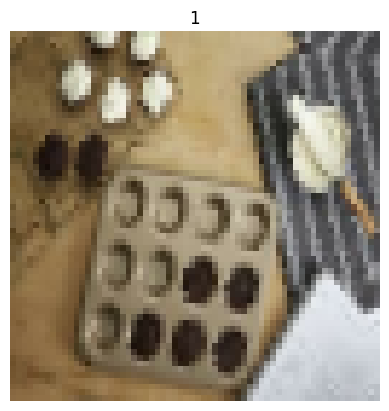

1/1 [==============================] - 0s 23ms/step
This image is 61.51% muffin and 38.49% chihuahua. and it should be 0


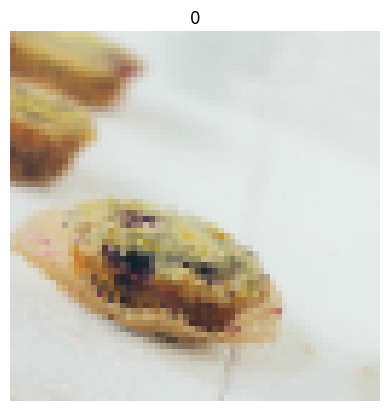

1/1 [==============================] - 0s 23ms/step
This image is 66.78% muffin and 33.22% chihuahua. and it should be 1


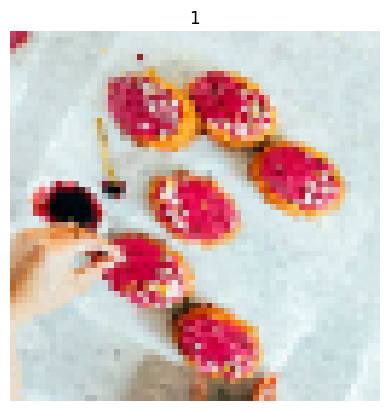

Epoch 1/50
119/119 [==============================] - 8s 28ms/step - loss: 0.7141 - accuracy: 0.5018 - val_loss: 0.6906 - val_accuracy: 0.5407
Epoch 2/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6988 - accuracy: 0.5209 - val_loss: 0.6902 - val_accuracy: 0.5385
Epoch 3/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6992 - accuracy: 0.5235 - val_loss: 0.6913 - val_accuracy: 0.5312
Epoch 4/50
119/119 [==============================] - 3s 23ms/step - loss: 0.6952 - accuracy: 0.5325 - val_loss: 0.6922 - val_accuracy: 0.5164
Epoch 5/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6985 - accuracy: 0.5248 - val_loss: 0.6892 - val_accuracy: 0.5459
Epoch 6/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6961 - accuracy: 0.5214 - val_loss: 0.6914 - val_accuracy: 0.5396
Epoch 7/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6959 - accuracy: 0.5309 - val_loss: 0.6916 - val_accuracy: 0.5428

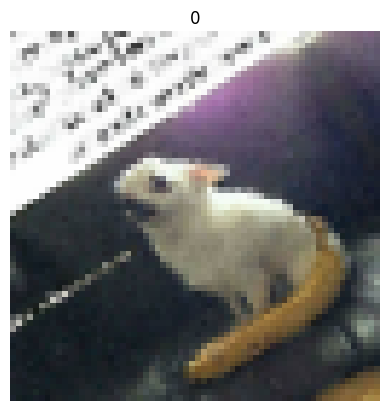

1/1 [==============================] - 0s 23ms/step
This image is 23.67% muffin and 76.33% chihuahua. and it should be 0


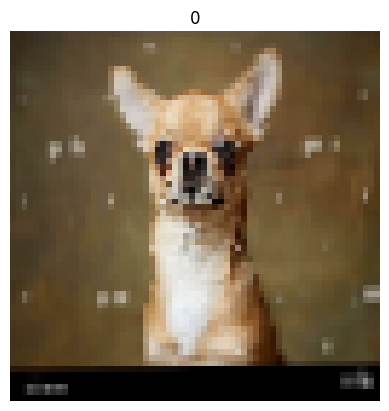

1/1 [==============================] - 0s 24ms/step
This image is 34.89% muffin and 65.11% chihuahua. and it should be 0


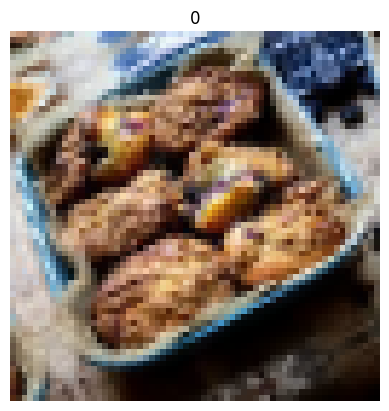

1/1 [==============================] - 0s 25ms/step
This image is 51.32% muffin and 48.68% chihuahua. and it should be 0


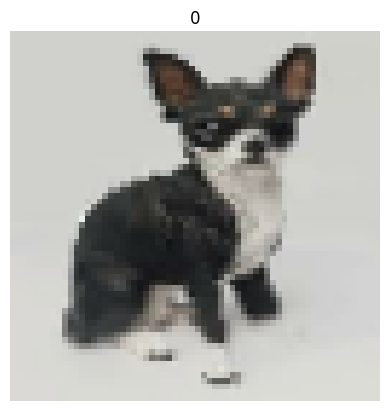

1/1 [==============================] - 0s 26ms/step
This image is 24.23% muffin and 75.77% chihuahua. and it should be 1


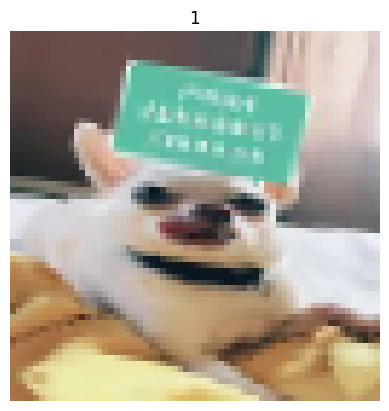

1/1 [==============================] - 0s 24ms/step
This image is 44.17% muffin and 55.83% chihuahua. and it should be 0


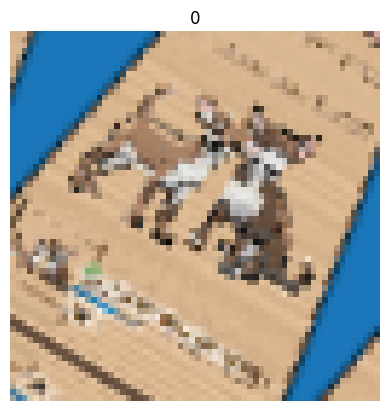

1/1 [==============================] - 0s 23ms/step
This image is 56.34% muffin and 43.66% chihuahua. and it should be 0


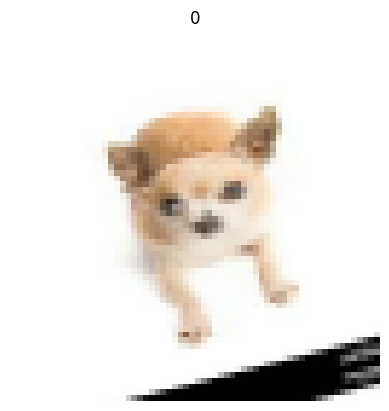

1/1 [==============================] - 0s 22ms/step
This image is 17.88% muffin and 82.12% chihuahua. and it should be 1


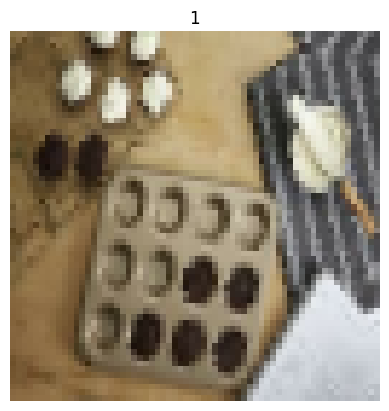

1/1 [==============================] - 0s 29ms/step
This image is 55.69% muffin and 44.31% chihuahua. and it should be 0


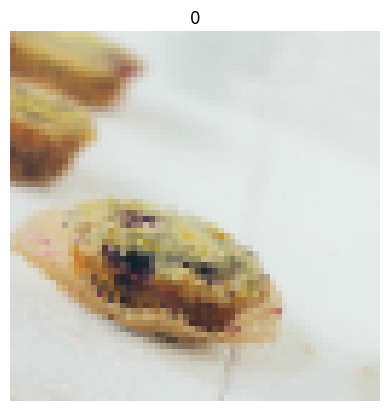

1/1 [==============================] - 0s 23ms/step
This image is 27.13% muffin and 72.87% chihuahua. and it should be 1


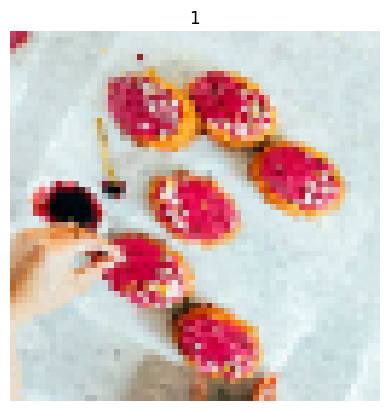

1/1 [==============================] - 0s 23ms/step
This image is 65.34% muffin and 34.66% chihuahua. and it should be 1


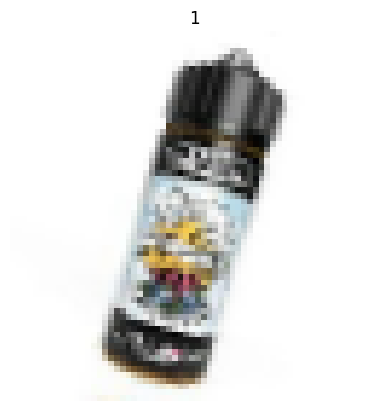

1/1 [==============================] - 0s 26ms/step
This image is 23.53% muffin and 76.47% chihuahua. and it should be 1


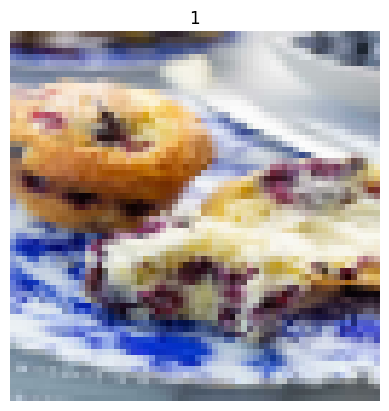

1/1 [==============================] - 0s 23ms/step
This image is 31.68% muffin and 68.32% chihuahua. and it should be 1


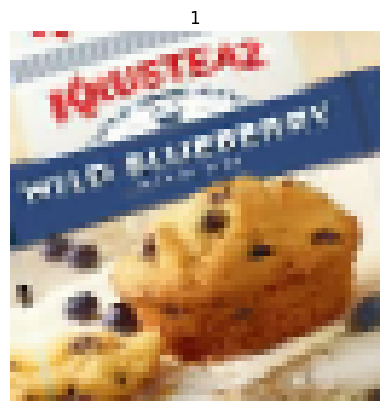

1/1 [==============================] - 0s 24ms/step
This image is 49.40% muffin and 50.60% chihuahua. and it should be 1


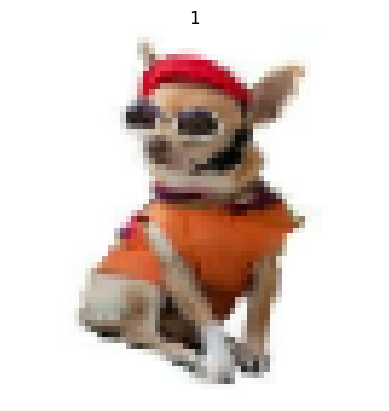

1/1 [==============================] - 0s 24ms/step
This image is 54.90% muffin and 45.10% chihuahua. and it should be 1


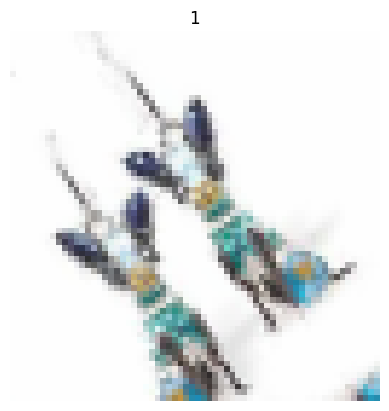

1/1 [==============================] - 0s 25ms/step
This image is 42.99% muffin and 57.01% chihuahua. and it should be 1


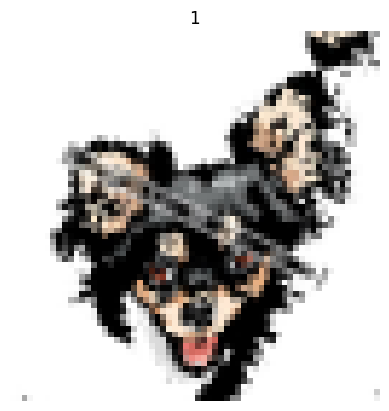

1/1 [==============================] - 0s 24ms/step
This image is 32.79% muffin and 67.21% chihuahua. and it should be 1


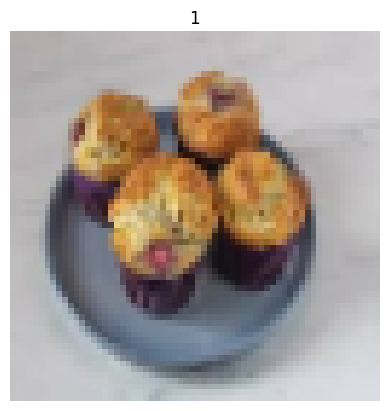

1/1 [==============================] - 0s 22ms/step
This image is 33.43% muffin and 66.57% chihuahua. and it should be 1


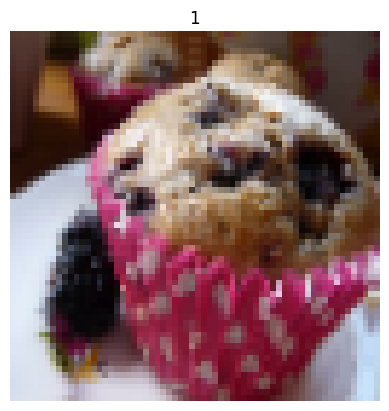

1/1 [==============================] - 0s 26ms/step
This image is 45.29% muffin and 54.71% chihuahua. and it should be 1


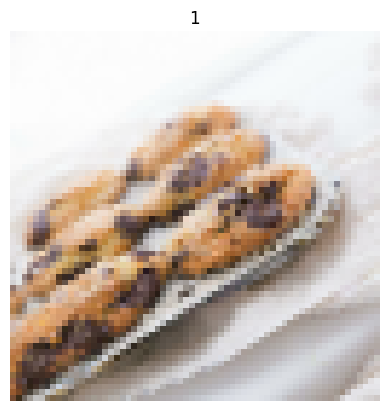

1/1 [==============================] - 0s 23ms/step
This image is 48.13% muffin and 51.87% chihuahua. and it should be 1


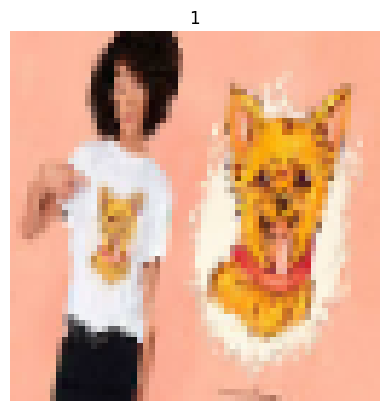

Epoch 1/50
119/119 [==============================] - 8s 27ms/step - loss: 0.7162 - accuracy: 0.5106 - val_loss: 0.6915 - val_accuracy: 0.5407
Epoch 2/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7040 - accuracy: 0.5148 - val_loss: 0.6923 - val_accuracy: 0.5016
Epoch 3/50
119/119 [==============================] - 3s 25ms/step - loss: 0.7015 - accuracy: 0.5261 - val_loss: 0.6952 - val_accuracy: 0.5037
Epoch 4/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7008 - accuracy: 0.5177 - val_loss: 0.6918 - val_accuracy: 0.5407
Epoch 5/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6966 - accuracy: 0.5322 - val_loss: 0.6931 - val_accuracy: 0.5407
Epoch 6/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6981 - accuracy: 0.5227 - val_loss: 0.7086 - val_accuracy: 0.5174
Epoch 7/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6954 - accuracy: 0.5367 - val_loss: 0.7088 - val_accuracy: 0.4826

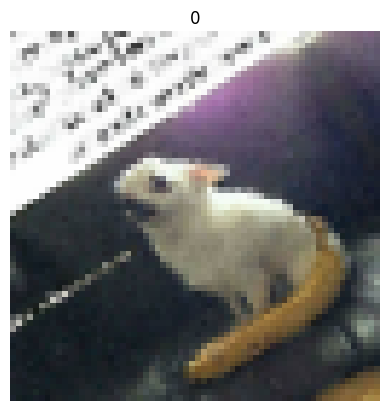

1/1 [==============================] - 0s 29ms/step
This image is 33.93% muffin and 66.07% chihuahua. and it should be 0


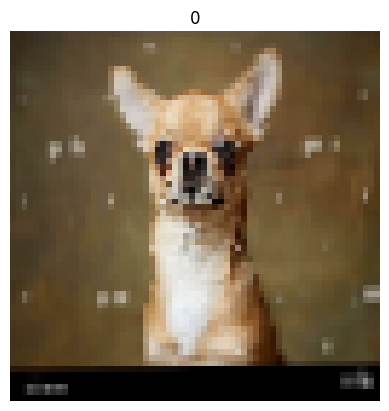

1/1 [==============================] - 0s 22ms/step
This image is 16.52% muffin and 83.48% chihuahua. and it should be 0


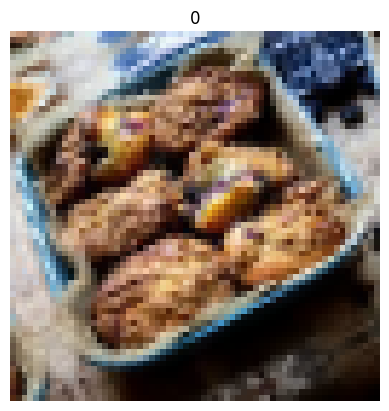

1/1 [==============================] - 0s 32ms/step
This image is 15.90% muffin and 84.10% chihuahua. and it should be 0


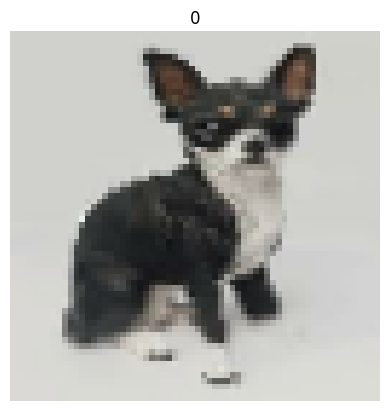

1/1 [==============================] - 0s 31ms/step
This image is 38.94% muffin and 61.06% chihuahua. and it should be 1


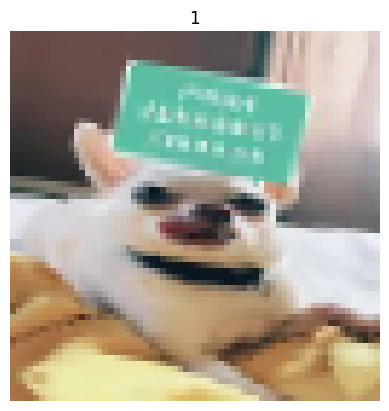

1/1 [==============================] - 0s 31ms/step
This image is 42.89% muffin and 57.11% chihuahua. and it should be 0


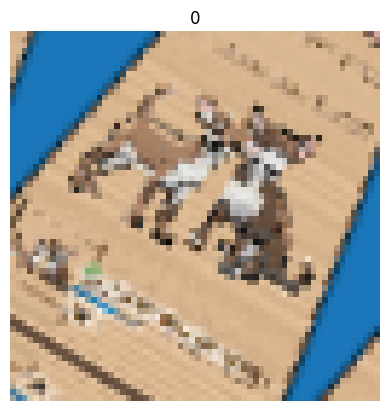

1/1 [==============================] - 0s 31ms/step
This image is 33.53% muffin and 66.47% chihuahua. and it should be 0


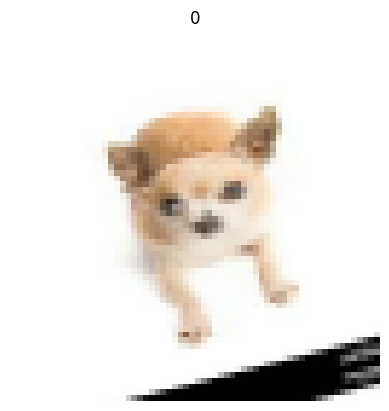

1/1 [==============================] - 0s 32ms/step
This image is 5.97% muffin and 94.03% chihuahua. and it should be 1


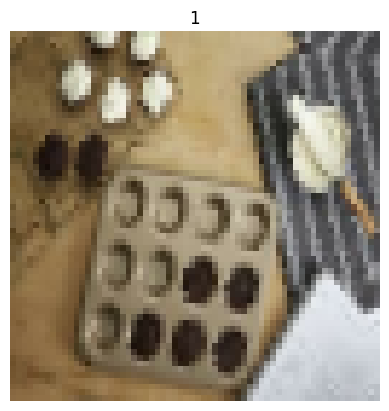

1/1 [==============================] - 0s 34ms/step
This image is 39.58% muffin and 60.42% chihuahua. and it should be 0


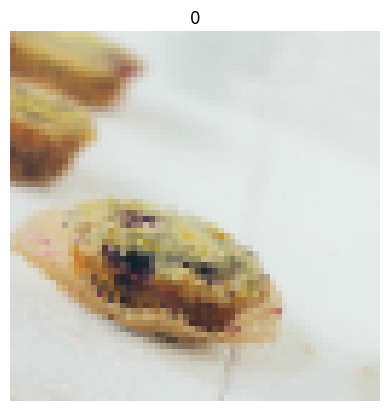

1/1 [==============================] - 0s 32ms/step
This image is 4.33% muffin and 95.67% chihuahua. and it should be 1


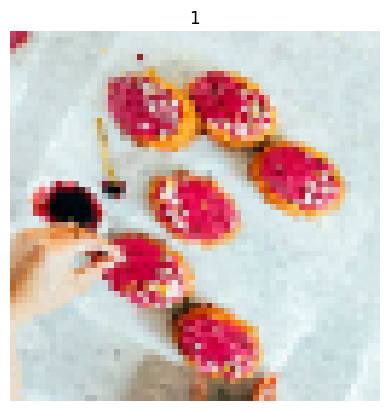

1/1 [==============================] - 0s 32ms/step
This image is 18.23% muffin and 81.77% chihuahua. and it should be 1


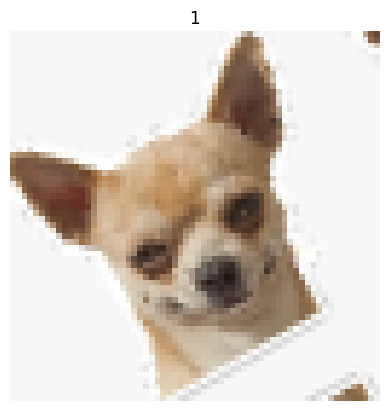

1/1 [==============================] - 0s 32ms/step
This image is 13.53% muffin and 86.47% chihuahua. and it should be 0


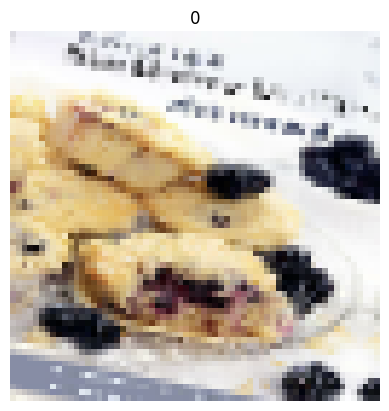

1/1 [==============================] - 0s 32ms/step
This image is 10.02% muffin and 89.98% chihuahua. and it should be 0


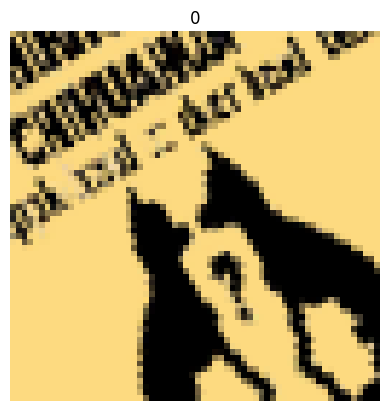

1/1 [==============================] - 0s 31ms/step
This image is 24.97% muffin and 75.03% chihuahua. and it should be 0


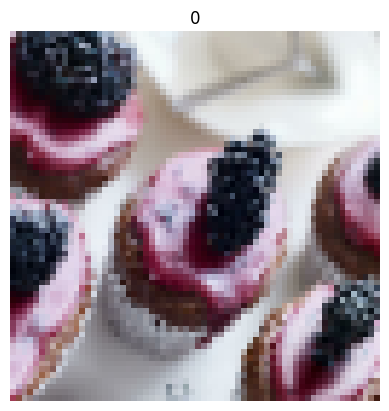

1/1 [==============================] - 0s 31ms/step
This image is 14.08% muffin and 85.92% chihuahua. and it should be 0


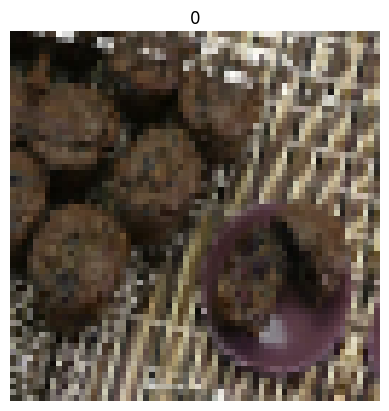

1/1 [==============================] - 0s 31ms/step
This image is 15.75% muffin and 84.25% chihuahua. and it should be 1


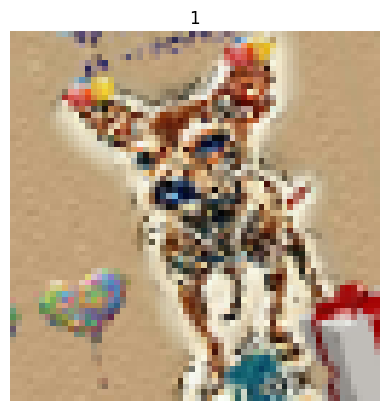

1/1 [==============================] - 0s 31ms/step
This image is 11.38% muffin and 88.62% chihuahua. and it should be 0


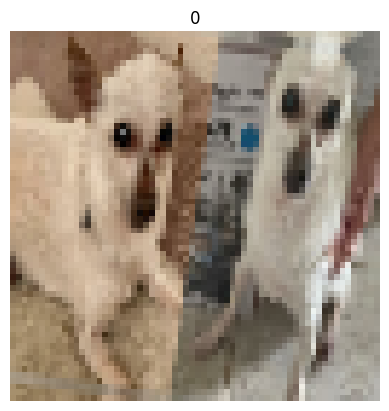

1/1 [==============================] - 0s 32ms/step
This image is 43.10% muffin and 56.90% chihuahua. and it should be 1


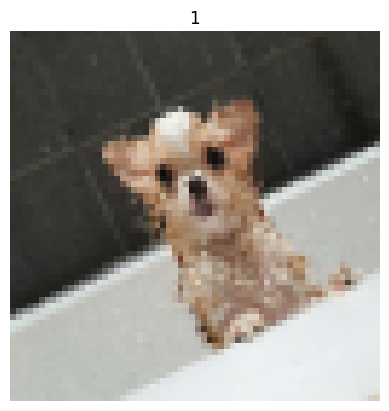

1/1 [==============================] - 0s 31ms/step
This image is 25.62% muffin and 74.38% chihuahua. and it should be 0


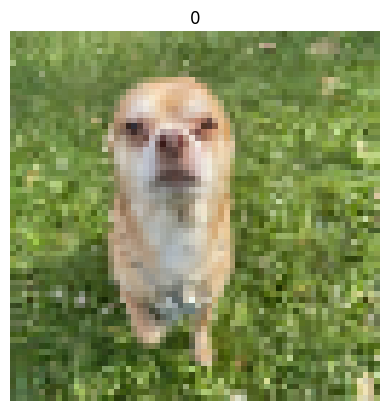

1/1 [==============================] - 0s 32ms/step
This image is 31.16% muffin and 68.84% chihuahua. and it should be 0


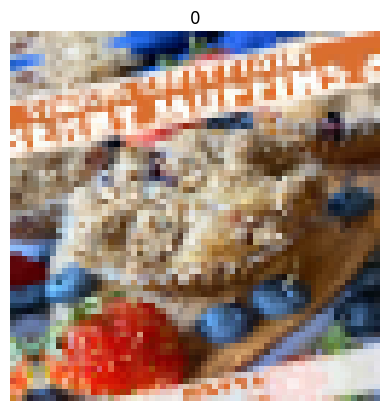

Epoch 1/50
119/119 [==============================] - 8s 27ms/step - loss: 0.7164 - accuracy: 0.5136 - val_loss: 0.6962 - val_accuracy: 0.4588
Epoch 2/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7041 - accuracy: 0.5070 - val_loss: 0.6989 - val_accuracy: 0.4588
Epoch 3/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7019 - accuracy: 0.5131 - val_loss: 0.6916 - val_accuracy: 0.5423
Epoch 4/50
119/119 [==============================] - 3s 25ms/step - loss: 0.6953 - accuracy: 0.5371 - val_loss: 0.6907 - val_accuracy: 0.5222
Epoch 5/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7009 - accuracy: 0.5226 - val_loss: 0.6949 - val_accuracy: 0.4926
Epoch 6/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6942 - accuracy: 0.5281 - val_loss: 0.6967 - val_accuracy: 0.5137
Epoch 7/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6929 - accuracy: 0.5360 - val_loss: 0.6917 - val_accuracy: 0.5317

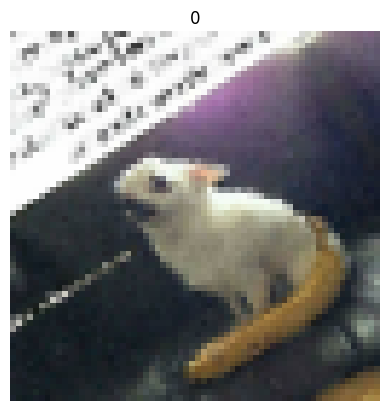

1/1 [==============================] - 0s 24ms/step
This image is 66.60% muffin and 33.40% chihuahua. and it should be 0


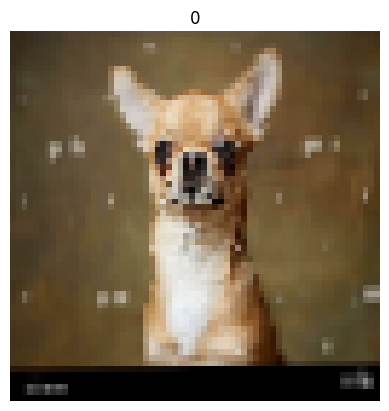

1/1 [==============================] - 0s 25ms/step
This image is 86.42% muffin and 13.58% chihuahua. and it should be 0


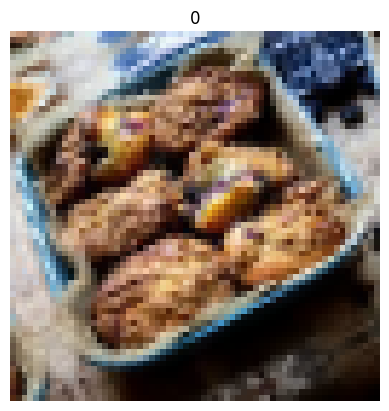

1/1 [==============================] - 0s 27ms/step
This image is 49.56% muffin and 50.44% chihuahua. and it should be 0


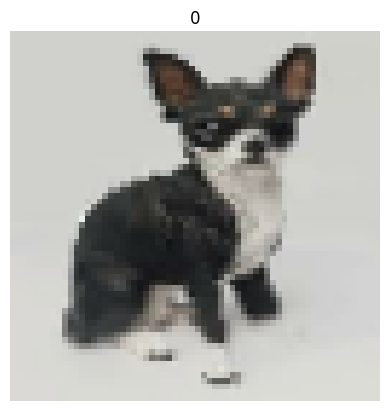

1/1 [==============================] - 0s 28ms/step
This image is 52.81% muffin and 47.19% chihuahua. and it should be 1


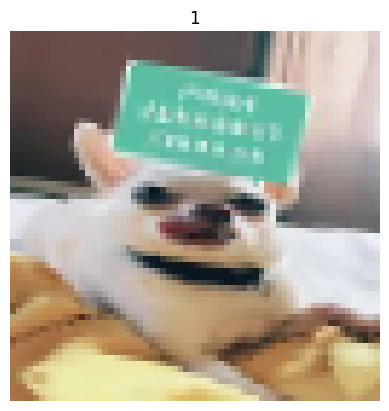

1/1 [==============================] - 0s 23ms/step
This image is 72.45% muffin and 27.55% chihuahua. and it should be 0


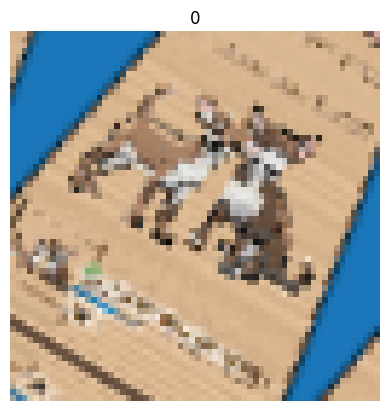

1/1 [==============================] - 0s 24ms/step
This image is 43.39% muffin and 56.61% chihuahua. and it should be 0


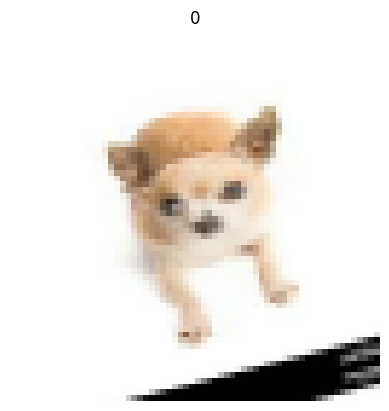

1/1 [==============================] - 0s 23ms/step
This image is 26.56% muffin and 73.44% chihuahua. and it should be 1


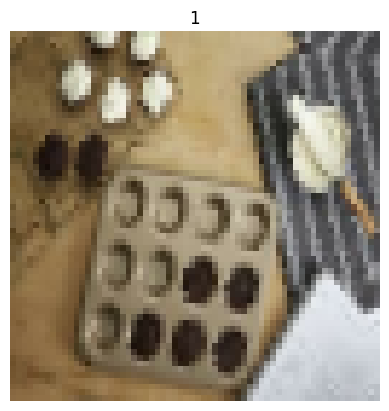

1/1 [==============================] - 0s 24ms/step
This image is 41.33% muffin and 58.67% chihuahua. and it should be 0


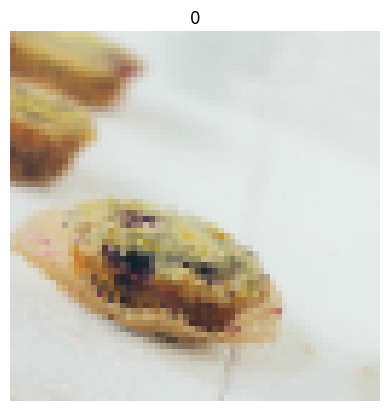

1/1 [==============================] - 0s 22ms/step
This image is 13.39% muffin and 86.61% chihuahua. and it should be 1


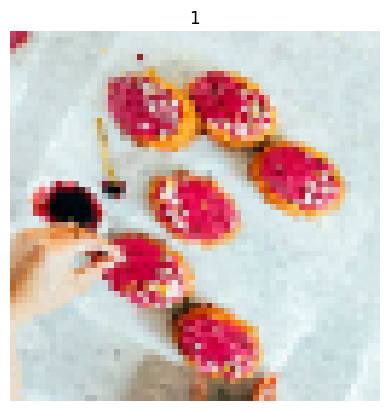

1/1 [==============================] - 0s 24ms/step
This image is 71.39% muffin and 28.61% chihuahua. and it should be 0


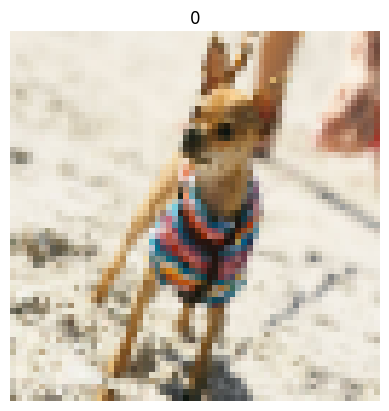

1/1 [==============================] - 0s 23ms/step
This image is 62.72% muffin and 37.28% chihuahua. and it should be 0


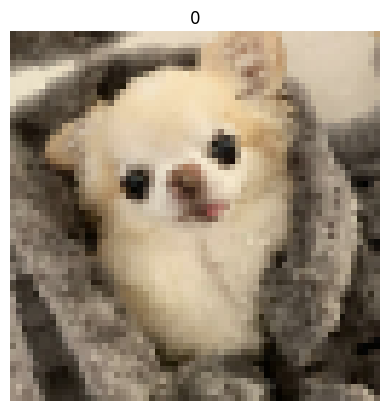

1/1 [==============================] - 0s 24ms/step
This image is 61.41% muffin and 38.59% chihuahua. and it should be 0


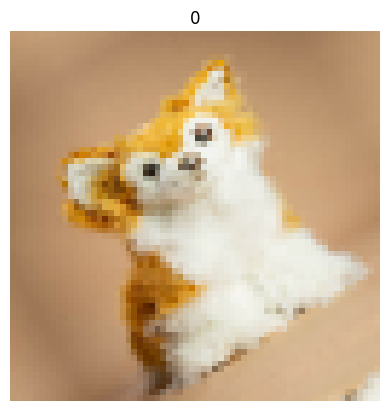

1/1 [==============================] - 0s 26ms/step
This image is 39.75% muffin and 60.25% chihuahua. and it should be 0


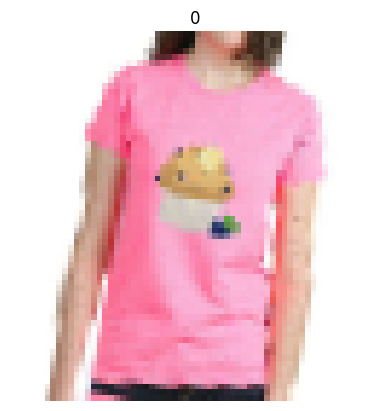

1/1 [==============================] - 0s 24ms/step
This image is 59.67% muffin and 40.33% chihuahua. and it should be 0


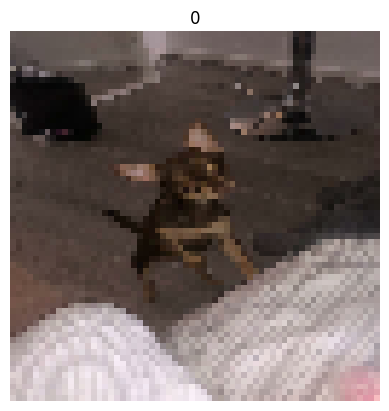

1/1 [==============================] - 0s 24ms/step
This image is 31.41% muffin and 68.59% chihuahua. and it should be 0


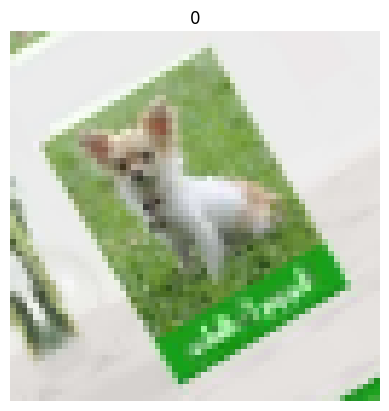

1/1 [==============================] - 0s 24ms/step
This image is 64.90% muffin and 35.10% chihuahua. and it should be 0


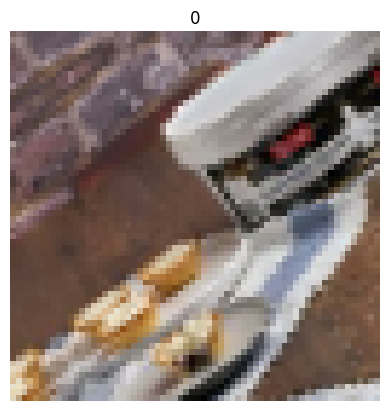

1/1 [==============================] - 0s 25ms/step
This image is 53.54% muffin and 46.46% chihuahua. and it should be 0


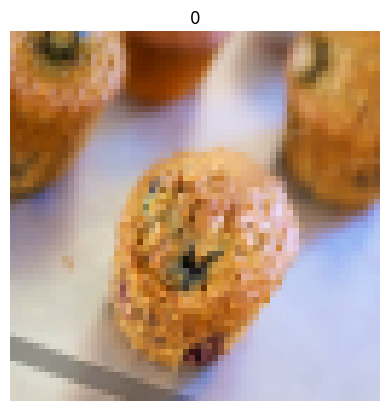

1/1 [==============================] - 0s 24ms/step
This image is 43.53% muffin and 56.47% chihuahua. and it should be 0


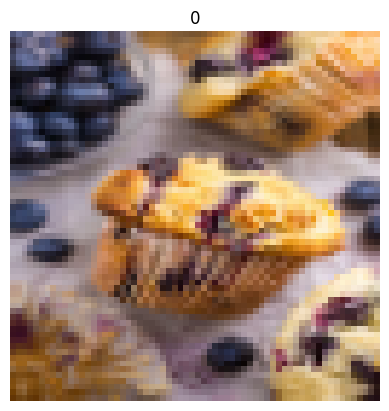

1/1 [==============================] - 0s 26ms/step
This image is 73.14% muffin and 26.86% chihuahua. and it should be 0


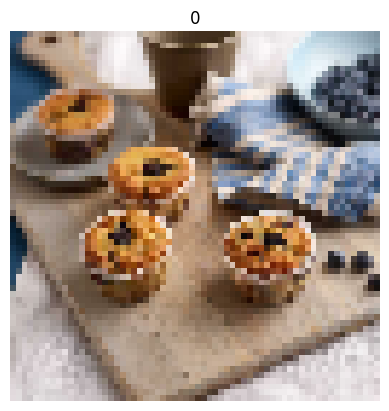

Epoch 1/50
119/119 [==============================] - 8s 28ms/step - loss: 0.7175 - accuracy: 0.5152 - val_loss: 0.6903 - val_accuracy: 0.5402
Epoch 2/50
119/119 [==============================] - 3s 25ms/step - loss: 0.7062 - accuracy: 0.5154 - val_loss: 0.6923 - val_accuracy: 0.5402
Epoch 3/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7047 - accuracy: 0.5096 - val_loss: 0.6950 - val_accuracy: 0.5402
Epoch 4/50
119/119 [==============================] - 3s 24ms/step - loss: 0.7004 - accuracy: 0.5191 - val_loss: 0.7013 - val_accuracy: 0.5159
Epoch 5/50
119/119 [==============================] - 3s 24ms/step - loss: 0.6952 - accuracy: 0.5260 - val_loss: 0.6968 - val_accuracy: 0.5243
Epoch 6/50
119/119 [==============================] - 3s 25ms/step - loss: 0.6990 - accuracy: 0.5231 - val_loss: 0.7439 - val_accuracy: 0.5402
Epoch 7/50
119/119 [==============================] - 3s 25ms/step - loss: 0.6930 - accuracy: 0.5347 - val_loss: 0.7445 - val_accuracy: 0.4524

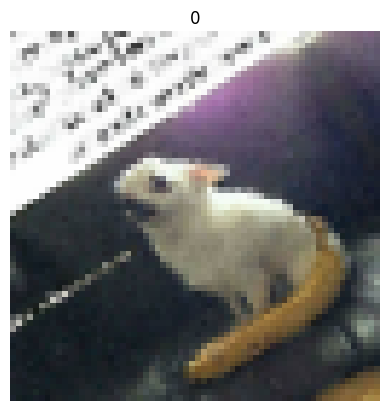

1/1 [==============================] - 0s 27ms/step
This image is 41.30% muffin and 58.70% chihuahua. and it should be 0


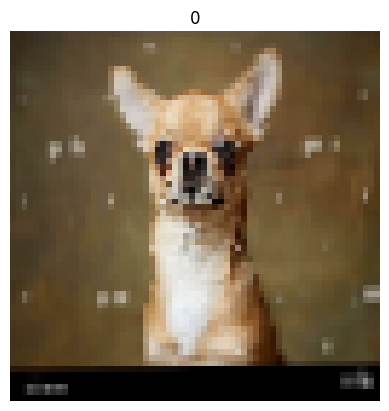

1/1 [==============================] - 0s 23ms/step
This image is 43.19% muffin and 56.81% chihuahua. and it should be 0


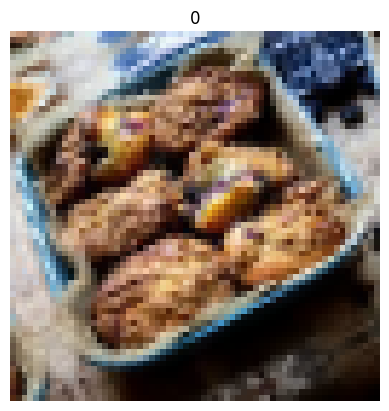

1/1 [==============================] - 0s 23ms/step
This image is 55.41% muffin and 44.59% chihuahua. and it should be 0


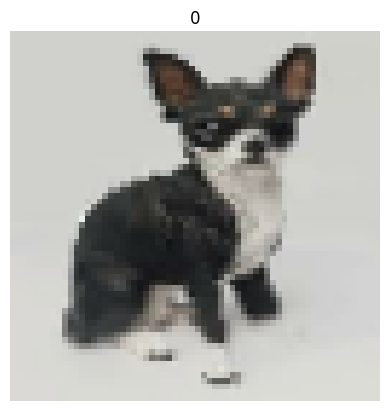

1/1 [==============================] - 0s 24ms/step
This image is 40.80% muffin and 59.20% chihuahua. and it should be 1


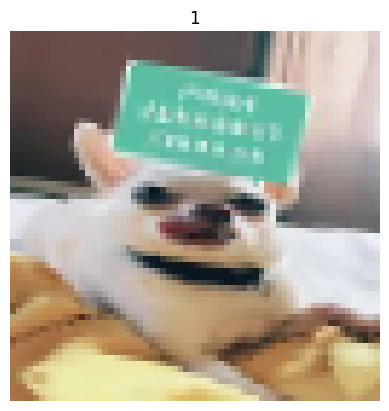

1/1 [==============================] - 0s 22ms/step
This image is 73.79% muffin and 26.21% chihuahua. and it should be 0


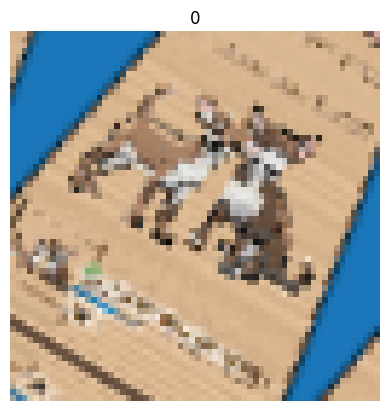

1/1 [==============================] - 0s 23ms/step
This image is 50.29% muffin and 49.71% chihuahua. and it should be 0


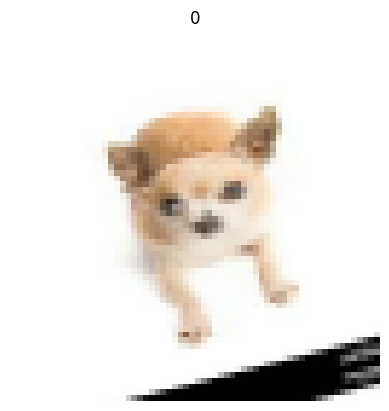

1/1 [==============================] - 0s 23ms/step
This image is 34.16% muffin and 65.84% chihuahua. and it should be 1


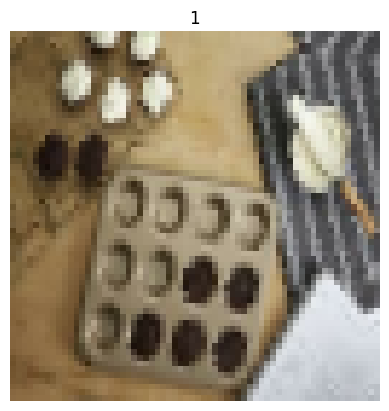

1/1 [==============================] - 0s 23ms/step
This image is 41.79% muffin and 58.21% chihuahua. and it should be 0


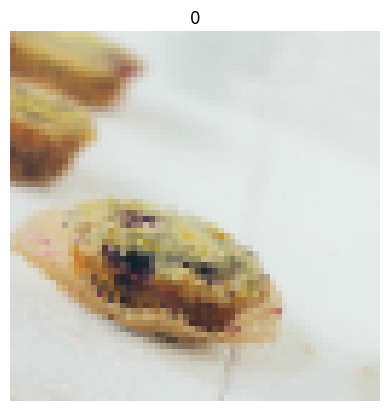

1/1 [==============================] - 0s 23ms/step
This image is 7.24% muffin and 92.76% chihuahua. and it should be 1


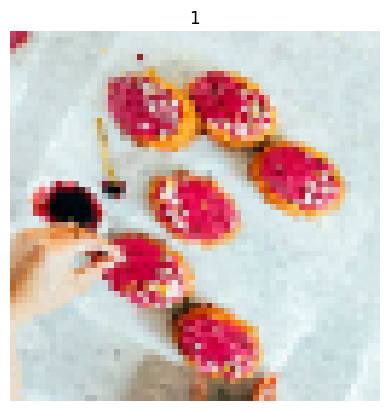

1/1 [==============================] - 0s 23ms/step
This image is 39.82% muffin and 60.18% chihuahua. and it should be 0


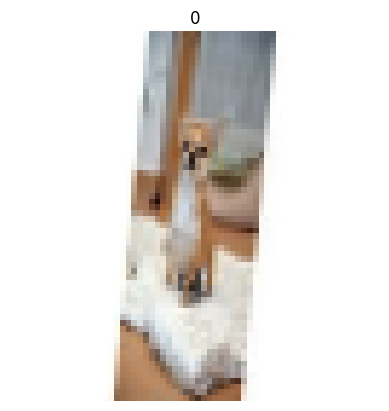

1/1 [==============================] - 0s 24ms/step
This image is 57.55% muffin and 42.45% chihuahua. and it should be 0


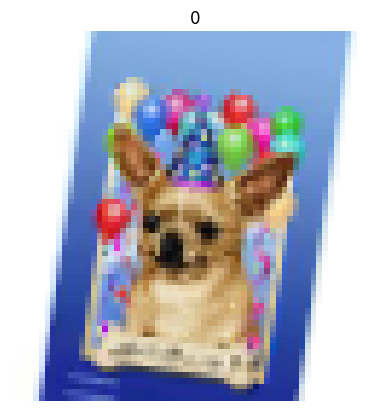

1/1 [==============================] - 0s 23ms/step
This image is 62.20% muffin and 37.80% chihuahua. and it should be 1


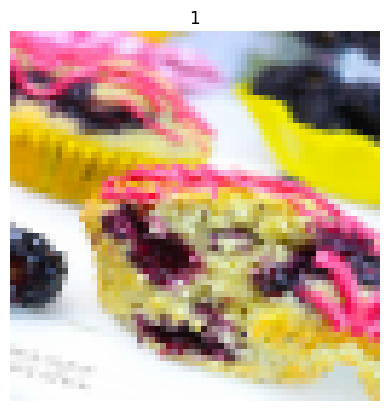

1/1 [==============================] - 0s 23ms/step
This image is 31.44% muffin and 68.56% chihuahua. and it should be 0


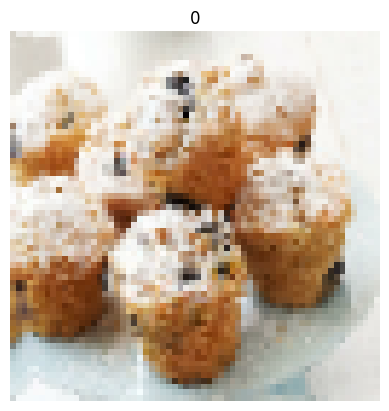

1/1 [==============================] - 0s 22ms/step
This image is 43.17% muffin and 56.83% chihuahua. and it should be 0


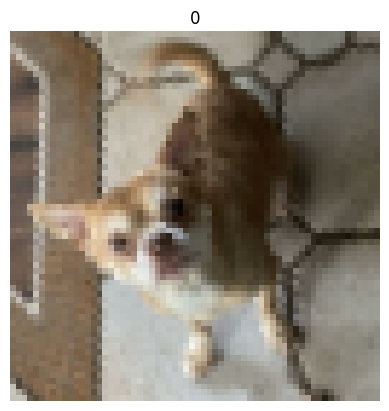

1/1 [==============================] - 0s 22ms/step
This image is 62.71% muffin and 37.29% chihuahua. and it should be 1


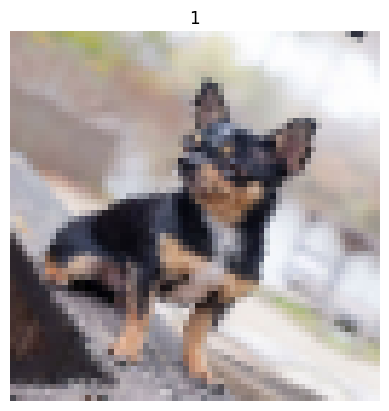

1/1 [==============================] - 0s 24ms/step
This image is 28.91% muffin and 71.09% chihuahua. and it should be 0


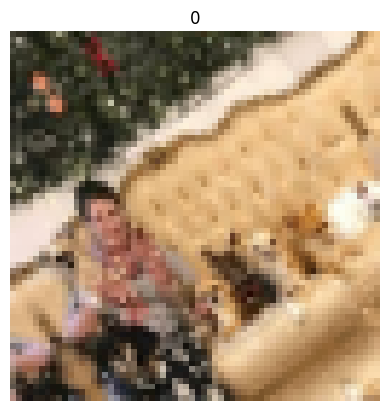

1/1 [==============================] - 0s 22ms/step
This image is 54.12% muffin and 45.88% chihuahua. and it should be 0


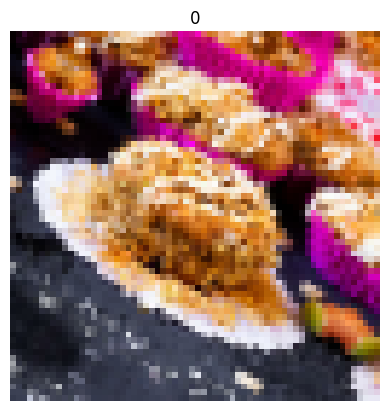

1/1 [==============================] - 0s 24ms/step
This image is 73.14% muffin and 26.86% chihuahua. and it should be 1


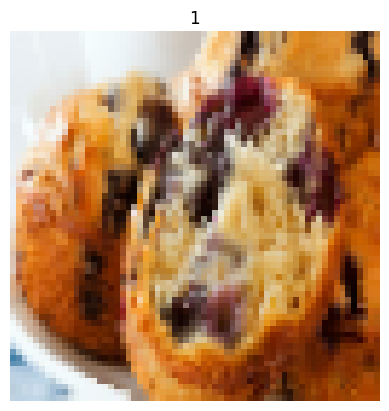

1/1 [==============================] - 0s 28ms/step
This image is 57.55% muffin and 42.45% chihuahua. and it should be 1


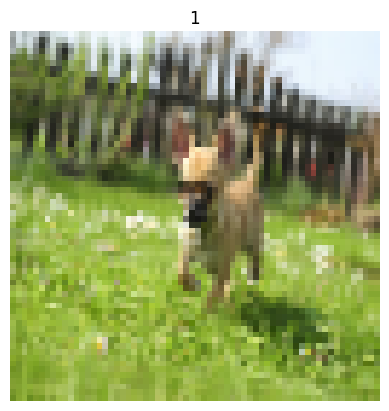

0.545108962059021

In [74]:
wandb.init(project='MuffinChihuahuas', config=configs)
val_accuracy = objective_5fold(wandb.config)
val_accuracy

In [ ]:
def main():
    wandb.init()
    val_accuracy = objective_5fold(wandb.config)
    wandb.log({'val_accuracy': val_accuracy})

# 2: Define the search space
sweep_configuration = {
    'method': 'bayes',
    'metric':
    {
        'goal': 'maximize',
        'name': 'val_accuracy'
    },
    'parameters':
    {
        'init_learning_rate': {
            'distribution': 'log_uniform_values', 'max': 1e-2, 'min': 1e-5
        },
        'batch_size': {
          # integers between 32 and 1024
          # with evenly-distributed logarithms
          'distribution': 'q_log_uniform_values',
          'q': 32,
          'min': 32,
          'max': 1024,
        },
        'dropout': {
          'values': [0.2, 0.3, 0.4, 0.5, 0.7]
        },
    }
}
sweep_configuration['parameters'].update({attribute:{'value':value} for attribute, value in configs.items()})

# 3: Start the sweep
sweep_id = wandb.sweep(
    sweep=sweep_configuration,
    project='MuffinChihuahuas'
)

wandb.agent(sweep_id, function=main, count=10)

Getting best values

In [ ]:
api = wandb.Api()
sweep = api.sweep(f"minigi/MuffinChihuahuas/sweeps/8mvl2ozv")

# Get best run parameters
best_run = sweep.best_run(order='val_accuracy')
best_parameters = best_run.config
print(best_parameters)

In [ ]:
best_run.summary

In [28]:
#wandb.init(project='MuffinChihuahua', config=best_parameters)
train, _, _ = load_datasets(wandb.config, use_val=False)
train = augment_dataset(train, show_preview=False)
print(len(train))
#train = train.unbatch()
train_x = np.concatenate([x for x, y in train], axis=0)
train_x.shape

Found 4733 files belonging to 2 classes.
Found 1184 files belonging to 2 classes.
148


(4733, 64, 64, 3)

In [25]:
train_x[0].shape

(64, 64, 3)

In [30]:
train_y = np.concatenate([y for x, y in train], axis=0)
train_y.shape

(4733,)

In [ ]:
for train_indexes, val_indexes in StratifiedKFold(n_splits=5).split(train_x, train_y):
  print("training", train_x[train_indexes].shape, train_y[train_indexes].shape)
  print(np.bincount(train_y[train_indexes]))
  print("validation", train_x[val_indexes].shape, train_y[val_indexes].shape)
  print(np.bincount(train_y[val_indexes]))

In [33]:
#train_ds, _, _ = load_datasets(wandb.config, use_val=False)

train_batched_x = list(train_ds.map(lambda x, y: x))
train_x = []
for batch in train_batched_x:
    for element in batch:
        train_x.append(element)
train_batched_y = list(train_ds.map(lambda x, y: y))
train_y = []
for batch in train_batched_y:
    for element in batch:
        train_y.append(element)

print(len(train_x), len(train_y))

4733 4733


In [38]:
int(train_y[1])

1

In [ ]:
! wandb sweep --stop minigi/MuffinChihuahuas/8mvl2ozv

In [ ]:
wandb.init(project='MuffinChihuahua', config=best_parameters)
print(wandb.config)
finale_value = objective_5fold(wandb.config)
print(final_value)
wandb.finish()

# Run inference on new data

In [ ]:
"""def keralize_img(path):
  img = keras.utils.load_img(
    path, target_size=configs.image_size
  )
  img_array = keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0)  # Create batch axis
  return img_array

chihuahua_img = keralize_img(dataset_path + '/test/muffin/img_0_67.jpg')
muffin_img = keralize_img(dataset_path + '/test/chihuahua/img_0_1107.jpg')

def predict(img):
  model.load_weights("/content/save_at_7.keras")
  predictions = model.predict(img)
  score = float(predictions[0])
  print(f"This image is {100 * (1 - score):.2f}% muffin and {100 * score:.2f}% chihuahua.")

predict(chihuahua_img)
predict(muffin_img)"""